## LAST.FM MUSIC RECOMMENDER 
### exploring matrix factorization and autoencoder in user-based collaborative filtering

## Problem Statement

Online music streaming services had become the dominant medium for users to 
access music. The purpose of a music recommender is two-fold: to create 
better user experiences and to increase the commercial value of streaming 
platforms. </b> 

For the term project we are interested in exploring collaborative filtering recomendation which typically consists of user-based and content-based appraoches. We will focused on user-based approach for it is the lighter approach that only takes into account users' past ratings of the songs. We will build two recommenders using a traditional approach of matrix factorization and a modern deep learning approach of deep autoencoder respectively. Subsequently, we will compare their performances in predicting users' preferences on songs masked as "unseen" and conduct analysis in relation to the nature of the data. 

## Content
- [Problem Statement](#Problem-Statement)
- [Related work](#Related-work)
- [Data Collection](#Data-Collection)
- [Data Exploration](#Data-Exploration)
- [Preprocessing](#Preprocessing)
- [Data Preparation](#Data-Preparation)
- [Building Recommenders](#Building-Recommenders)
    - [Matrix Factoriazaition Pipeline](#Matrix-Factoriazaition-Pipeline)
    - [Deep Autoencoder Pipeline](#Deep-Autoencoder-Pipeline)
- [Prediction](#Prediction)
- [Analysis](#Analysis)
- [Conclusion](#Conclusion)
- [Future Investigation](#Future-Investigation)

## Related Work


While matrix factorization method with SVD had been the traditonally popular in collaboratie filtering based recommender systems, recent effort have increasing migrated toward deep learning technique. Kuchaiev and Ginsburg [1] had proposed a recommender architecture built using deep autoencoders. The authors found that the deep autoencoders generalized better than shallow once; while the use of non-linear activation with negative parts helps propagate gradients and finally, the heavy use of drop-out and regularization is crucial in preventing overfitting. Li et al [2] pointed out that traditional technique such as matrix factorization fall short on capturing non-linaring in the user-item interaction. They had demonstrated the potentials of a deep neural network while highlighting the challenge in training and overfitting. We follow closely techniques used the these papers, preprocessing of sparse input data, denosing using dropout as well as using computing loss with a zero-mask. 

[1]CollaborativeAutoencoderforRecommenderSystems
https://pdfs.semanticscholar.org/838e/9ddc41b6badb9bf1f64cd7e2a18f8adda057.pdf

[2]TrainingDeepAutoEncodersforCollaborativeFiltering 
https://arxiv.org/pdf/1708.01715.pdf

## Data Collection
We will mainly use Last.fm api to collect our data, where we can retrieve a set of users and their N most frequently played songs in a most recent window of time (for this project, the window is one month). The Last.fm API had provided just such method: `User.getTopTracks`. The caveat of using this method is that we'll need to pass in list of usernames as argument, which is not readily available for privacy reason. To get around this challenge, we will use the search phrase `site:last.fm/user/` on popular search engine website and scrape usernames. Our experiments had showed Bing by far returned the most number of usernames. __Importantly, as a good privacy practice, make sure that usernames are hashed before publishing any parts of the data harvested.__

In [1]:
import time
import re
from bs4 import BeautifulSoup
import urllib.request
import numpy as np
import progressbar
import pylast
import os
import operator
import scipy.sparse as sp
import matplotlib.pyplot as plt
from collections import OrderedDict

In [2]:
API_KEY = "389968e3566746e89cbb4750271c3aa1"
API_SECRET = "a96e6333143c6f686fd045a41acf1f4e"
PATH_USERNAMES = "dataset/usernames.npy"
PATH_SONGS = "dataset/songs.npy"
PATH_RATINGS = "dataset/ratings.npy"
PATH_MATRIX = "dataset/matrix.npz"
PATH_RATING_DICT = "dataset/rating_dict.npy"
PATH_MODEL = "model/ae.model"

In [3]:
def get_username_from_url(request):
    res = set()
    with urllib.request.urlopen(request) as urlObject:
        html = urlObject.read()
        soup = BeautifulSoup(html, "html.parser")
        results = soup.findAll('li', { "class" : "b_algo" })
        for result in results:
            result = str(result.find('a').get('href'))
            username = re.search(r'https:\/\/[^\.]+.last.fm\/user\/([^\/]+)', result)
            if username is not None:
                res.add(username.group(1))
            else:
                print('failed to fetch username in', result)
    return res

In [4]:
def bing_search():
    print('crawling usernames from Bing')
    url = "https://www.bing.com/search?q=site%3alast.fm%2fuser%2f&qs=ds&first={0}&FORM=PERE"
    headers = {'User-Agent':'Chro/5.0 (Windows NT 10.0; Win64; x64; rv:54.0) Gecko/20100101 Firefox/54.0'}
    res = set()
    start = 1
    address = url.format(start)
    request = urllib.request.Request(address, None, headers)
    res = res.union(get_username_from_url(request))
    start = 15
    total = 1000
    with progressbar.ProgressBar(max_value=total) as bar:
        while start < total:
            address = url.format(start)
            request = urllib.request.Request(address, None, headers)     
            res = res.union(get_username_from_url(request))
            start += 10
            bar.update(min(start, total))
            time.sleep(1)
    print('crawled %d usernames from bing search'%len(res))
    return res

In addtion to crawling Bing to scrape usernames (returns 768 names), we will use Last.fm's api method `user.get_friends()` to find user's friends to ensure we have big enough of a dataset. With a "depth=1" search, we are able to get 9682 users.

In [5]:
network = pylast.LastFMNetwork(api_key=API_KEY, api_secret=API_SECRET)

def crawl_user_friends(usernames, depth=1, max_friends=0):
    usernames = usernames[:]
    for i in range(depth):
        print('fetching list of usernames with a depth of %d'%depth)
        assert len(usernames) == i+1
        friends = set()
        # traverse each user in last depth
        with progressbar.ProgressBar(max_value=len(usernames[i])) as bar:
            for j, username in enumerate(usernames[i]):
                user = network.get_user(username)
                try:
                    n = 0
                    for friend in user.get_friends():
                        recorded = False
                        for prev in usernames: # check if friend is already recorded in previous depths
                            if friend.get_name() in prev:
                                recorded = True
                        if not recorded:
                            friends.add(friend.get_name())
                            n += 1
                        if max_friends and n >= max_friends:
                            break
                except:
                    pass
                finally:
                    bar.update(j)
        usernames.append(friends)
    return usernames

In [6]:
def get_usernames():
    # TODO refer to cache funtions in previous hw
    path = os.path.join(os.getcwd(), PATH_USERNAMES)
    if os.path.isfile(path):
        return np.load(path, allow_pickle=True)
    dataset = crawl_user_friends([bing_search()], depth=1, max_friends=20)
    dataset = np.array(list(set.union(*dataset)), dtype=object)
    np.save(path, dataset)
    return dataset

In [61]:
USERNAMES = get_usernames()

crawling usernames from Bing


100% (1000 of 1000) |####################| Elapsed Time: 0:02:11 Time:  0:02:11


crawled 768 usernames from bing search
fetching list of usernames with a depth of 1


100% (768 of 768) |######################| Elapsed Time: 0:42:58 Time:  0:42:58


In [7]:
USERNAMES = get_usernames()

During the process of scrape username te found out There is a limitation in the original method of `pylast._collect_nodes`

In [8]:
import xml.dom
def _collect_nodes(limit, sender, method_name, cacheable, params=None):
    """
    Returns a sequence of dom.Node objects about as close to limit as possible
    """

    if not params:
        params = sender._get_params()

    nodes = []
    page = 1
    end_of_pages = False

    while not end_of_pages:
        params["page"] = str(page)

        tries = 1
        while True:
            try:
                doc = sender._request(method_name, cacheable, params)
                break  # success
            except Exception as e:
                if tries >= 3:
                    raise e
                # Wait and try again
                time.sleep(1)
                tries += 1

        doc = pylast.cleanup_nodes(doc)

        # break if there are no child nodes
        if not doc.documentElement.childNodes:
            break
        main = doc.documentElement.childNodes[0]

        if main.hasAttribute("totalPages"):
            total_pages = pylast._number(main.getAttribute("totalPages"))
        elif main.hasAttribute("totalpages"):
            total_pages = pylast._number(main.getAttribute("totalpages"))
        else:
            raise Exception("No total pages attribute")

        for node in main.childNodes:
            if not node.nodeType == xml.dom.Node.TEXT_NODE:
                nodes.append(node)

        if page >= total_pages:
            end_of_pages = True

        page += 1

    return nodes

# overide pylast's method
pylast._collect_nodes = _collect_nodes

Now we will use Last.fm's api method `network.get_user(username)` to find out whether this username is valid. Then we will is use Last.fm's api method `user.get_top_tracks` to collected all the play records assciated with this valid user in one month.  
With 9682 requests, we are able to collect 6360 valid users with their play records. <br>
We stored these records in a dictionary:<br>
`{'user_1':{ 'Album','Artist' : 'playcount'},
...
{'user_N':{ 'Album','Artist' : 'playcount'}}`

In [9]:
def get_dictionary(usernames=USERNAMES):
    
    # check if there exists rating matrix
    path_rating_dict = os.path.join(os.getcwd(), PATH_RATING_DICT)
    if os.path.isfile(path_rating_dict):
        return np.load(path_rating_dict, allow_pickle=True).item()
    
    d = {} # {username: {(song, artist): playcount}}
    with progressbar.ProgressBar(max_value=len(usernames)) as bar:
        for user_index, username in enumerate(usernames):
            try:
                user = network.get_user(username)
                tracks = user.get_top_tracks(period="1month", limit=1000, cacheable=True) # todo test cacheable
                if username not in d and len(tracks):
                    d[username] = {}
                for item in tracks:
                    track, play_count = item
                    key =(track.get_artist().get_name(), track.get_name())
                    d[username][key] = play_count
            except Exception as e:
                pass
            finally:
#                 with open(path_rating_dict, 'w') as f:
                np.save(path_rating_dict, d)
    return d

## Explore data
Now that we have successfully generated a disctionary of user-songs mapping, let's visualize it to better understand the underlying nature of the data. We have successful gather song ratings from 9,682 users, with a combined number of 1,780,000 songs. We observe an exponential distribution in both user activies (number of unique songs per user) and the listeners per songs. This indicates that a few number of hyper-ative users accounts for most of the user activities while a few popular songs amass most of the popularity. For most users, we also observe that far fewers songs have high play counts while the majority songs had only been listened to only a number of times. This is typically the case for most user-product matrix for there are far more products than ratings, while there are orders of magnitude more songs that a user glosses over than the few that ended up getting listened to repeadtly. 

In [223]:
user_play_dict = get_dictionary()
print('Number of Valid Users: %d'% len(user_play_dict))
print('Number of Valid Songs: %d'% sum(map(len, user_play_dict.values())))

100% (9682 of 9682) |####################| Elapsed Time: 9:50:11 Time:  9:50:11


In [10]:
user_play_dict = get_dictionary()
print('Number of Valid Users: %d'% len(user_play_dict))
print('Number of Valid Songs: %d'% sum(map(len, user_play_dict.values())))

Number of Valid Users: 6360
Number of Valid Songs: 4847252


##  Data Preprocessing
Given our observation, we have manually set up parameters to purge the outliers in the long tail of the exponential distribution, that is, users who had only listened to a few songs (in the past month) or songs that had rarely been listened to. 
<br><br>
But we still face the question of how to convert user's playcounts into a rating for a given song. To contraint the wide range of playcounts, we will use the logarithmic scale instead of the linear scale. Subsequently we have normalized the log playcount for each users to generate a relative user rating from [0.1 to 1]. We perform this transformation with the assumption that playcounts indicates how much a user favor the song, thus the more playcounts yields higher ratings.  

In [12]:
def normalize_ratings(play_count):
    if not len(play_count):
        return play_count
    play_count = np.log(np.array(play_count, dtype=np.float))
#     play_count = np.sqrt(np.log(np.array(play_count, dtype=np.float)))
    max_count = np.max(play_count)
    if max_count > 0:
        play_count /= max_count
    play_count = play_count*0.9 + 0.1
    return play_count.tolist()

In [13]:
def purge_rating_dict(user_play_dict, min_songs, min_users):
    """
    1. remove users with only a few played songs (<min_songs)
    2. remove songs played by only a few users (<min_users)
    3. normalize playcounts
    4. return user_index_list, song_index_list, user_list, song_list, rating_list
    """
    # List for build up Matrix
    user_indices = []
    song_indices = []

    rating_list = []
    user_list = []
    song_list = []

    # remove users with only a few played songs (<min_songs)
    remove_user_list = []
    print('user num:', len(user_play_dict), end='')
    for user in user_play_dict:
        if len(user_play_dict[user]) < min_songs:
            remove_user_list.append(user)
            
    for key in remove_user_list:
        if key in user_play_dict:
            del user_play_dict[key]
            
    print('->', len(user_play_dict), end='\n')
    
    # remove songs played by only a few users (<min_users)
    song_dict = {}
    remove_songs = set()
    for keys, values in user_play_dict.items():
        for song in values:
            song_dict[song] = song_dict.get(song, 0) + 1
    print('song num :', len(song_dict), end='')
    for key in song_dict:
        if song_dict[key] < min_users:
            remove_songs.add(key)
            
    for key in remove_songs:
        if key in song_dict:
            del song_dict[key]
    print('->', len(song_dict), end='\n')
    
    d = {}
    for name in user_play_dict.keys():
        ratings = []
        _remove_songs = []
        _remove_users = []
        for k, v in user_play_dict[name].items():
            if k in remove_songs:
                _remove_songs.append(k)
                continue
            if k not in d:
                song_indices.append(k)
                d[k] = len(d)
            user_list.append(len(user_indices))
            song_list.append(d[k])
            ratings.append(v)
        if len(ratings):
            rating_list.extend(normalize_ratings(ratings))
            user_indices.append(name)
        else:
            _remove_users.append(name)
        for s in _remove_songs:
            if s in user_play_dict[name]:
                del user_play_dict[name][s]
    for u in _remove_users:
        if u in user_play_dict:
            del user_play_dict[u]
    
    return rating_list, user_list, song_list, user_indices, song_indices

In [14]:
path_rating_dict = os.path.join(os.getcwd(), PATH_RATING_DICT)
user_play_dict = np.load(path_rating_dict, allow_pickle=True).item()
rating_list, user_list, song_list, user_indices, song_indices = purge_rating_dict(user_play_dict, min_songs=10, min_users=50)

user num: 6360-> 6246
song num : 1780000-> 8496


In [15]:
def processVisual(dt):
    song_dict = {}
    user_dict = {}
    remove_songs = set()
    for key, values in dt.items():
        user_dict[key] = len(values)
        for song in values:
            song_dict[song] = song_dict.get(song, 0) + 1
        
    return song_dict, user_dict

song_dict, user_dict = processVisual(user_play_dict)

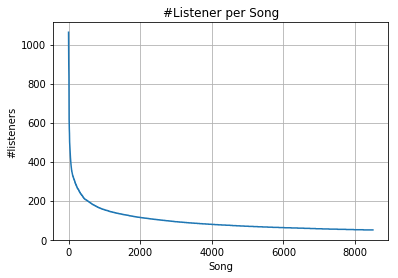

In [16]:
# Music Listened By Number of Users
def plot_Users_Music(song_dict):            
    song_list = []
    song_list = sorted(song_dict.items(), key=operator.itemgetter(1),reverse=True)
    x = []
    for i in song_list:
        x.append(i[1])
    fig, ax = plt.subplots()
    ax.set(xlabel='Song', ylabel='#listeners',
           title='#Listener per Song')
    ax.grid()

    ax.plot(np.arange(len(x))+1, x, label='')
    fig.savefig("test.png")
    plt.show()
    
plot_Users_Music(song_dict)

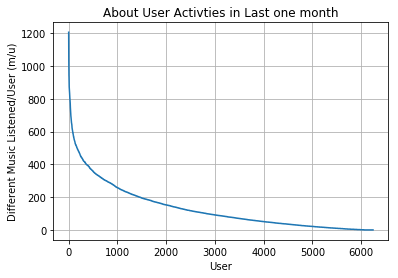

In [17]:
# About User Activities in last Month
def plot_Users_Activ(user_dict):
    user_list = []
    user_list = sorted(user_dict.items(), key=operator.itemgetter(1),reverse=True)
    x = []
    for i in user_list:
        x.append(i[1])
    fig, ax = plt.subplots()
    ax.set(xlabel='User', ylabel='Different Music Listened/User (m/u)',
           title='About User Activties in Last one month')
    ax.grid()

    ax.plot(np.arange(len(x))+1, x, label='')
    fig.savefig("test.png")
    plt.show()

plot_Users_Activ(user_dict)

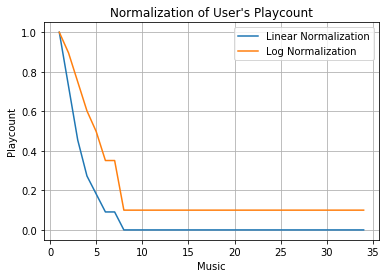

In [18]:
# Normalization Of User Playcount
def plot_User_Normalization(user):
    picked_user = user
    picked_user_track = sorted(user_play_dict[picked_user].items(), key=operator.itemgetter(1),reverse=True)
    play_count = []
    for i in picked_user_track:
        play_count.append(i[1])

    # call normalization
    play_count_2 = normalize_ratings(play_count)

    play_count = np.array(play_count)
    max_count = np.max(play_count)
    min_count = np.min(play_count)
    if max_count > 0:
        play_count = (play_count - min_count)/(max_count-min_count)

    # play_count.tolist()
    fig, ax = plt.subplots()
    ax.set(xlabel='Music', ylabel='Playcount',
           title='Normalization of User\'s Playcount')
    ax.grid()

    ax.plot(np.arange(len(play_count))+1, play_count, label='Linear Normalization')
    ax.plot(np.arange(len(play_count_2))+1, play_count_2, label='Log Normalization')
    fig.savefig("test.png")
    plt.legend(title='')
    plt.show()

random_user = list(user_play_dict)[21]
plot_User_Normalization(random_user)

## Data Preparation


Now that We have completed data cleaning and preprocessing, it's time the prepare the data for the recommender training pipelines. We will first combine the lists of users IDs, song IDs and user ratings into a user-song matrix, with each entries being the user's rating [0.1, 1] and 0 if the song is unseen by the user. We will then split the matrix into three identically shaped matrixes: a training, validation and test matrix by randomly selecting a percentage of entries for each matrix(train=70%, val=20%, test=10%), while keep the rest entries zeros. The training set is used for training, while the validation set helps us tune the model and prevent overfitting. Finally, we will compare the user's actual rating in the test set against the predictions made by recommender. To help improve memory efficiency, we will use scipy's sparse matrix to store out training, validation and test data.

In [19]:
from sklearn.model_selection import train_test_split
def split_dataset(data, row, col, val_size=0.2, test_size=0.1, random_state=0xDECAFE):

    train_userid, test_userid, train_songid, test_songid, train_rating, test_rating = train_test_split(row, col, data, test_size=0.1, random_state=random_state)
    train_userid, val_userid, train_songid, val_songid, train_rating, val_rating = train_test_split(train_userid, train_songid, train_rating, test_size=0.2, random_state=random_state)
    
    # Split matrix
    matrix_train = sp.coo_matrix((train_rating, (train_userid, train_songid)), shape=(len(user_indices), len(song_indices)))
    matrix_val = sp.coo_matrix((val_rating, (val_userid, val_songid)), shape=(len(user_indices), len(song_indices)))
    matrix_test = sp.coo_matrix((test_rating, (test_userid,
                                               test_songid)), shape=(len(user_indices), len(song_indices)))
    return matrix_train, matrix_val, matrix_test

In [20]:
matrix_train, matrix_val, matrix_test = split_dataset(rating_list, user_list, song_list)

## Building Recommenders

Before we start building our recommender models, it's important to get an overview of what they do. Recall that we have an extremely sparse user-song rating matrix. In user-based collaborative filtering, the recommender algorithm learns a representation of the underlying data distribution and "densifies" the sparse matrix in the process. This is true for both matrix factorization and deep autoencoder, which essentially peform dimension reduction of the data, similar to the function of PCA. For instance, the "k" parameter determining the later-feature dimension in matrix factorization is the equavilent to choosing the top k eigenvectors and eigenvalues in PCA. Similarly, autoencoder distills the dimensions of the input data by forcing it through a bottle-neck layer. 

With this in mind, we are ready to build our recommenders. 

### Matrix Factorization Pipeline

In collaborative filtering, we take the user-song rating matrix and attempts to factorize it into user-latent features and song-latent features. By viewing rating as the product of both user and song properties, we can predict a user's ratings on song they have not yet listened to.

Given the sparsely filled rating matrix $X\in \mathbb{R}^{m\times n}$, we are going to find feature matrices $U \in \mathbb{R}^{m\times k}$ and $V \in \mathbb{R}^{n\times k}$ such that $UV^T = X$.
Each row of $U$ is a feature-vector corresponding to a user, each row of $V$ is a feature-vector corresponding to a song. $u_i^Tv_j$ is the predicted rating of user $i$ on movie $j$. We will use scipy's singular value decomposition method `Scipy.linalg.svds` to factorize the matrix and mean square error for evaluating the reconstruction loss.

In [21]:
# cite: error computation taken from 688 hw4_cf
import scipy.linalg as la
import time

def error(X, U, V):
    """ Compute the mean error of the observed ratings in X and their estimated values. 

        args: 
            X : np.array[num_users, num_movies] -- the ratings matrix
            U : np.array[num_users, num_features] -- a matrix of features for each user
            V : np.array[num_movies,num_features] -- a matrix of features for each movie

        return: float -- the mean squared error between non-zero entries of X and the ratings
            predicted by U and V; as this is an error and not a loss function, you do not need to include the
            regularizing terms.
        """
    return np.sum(np.square(np.multiply(np.sign(X), (X - np.dot(U, V)))))/np.sum(X!=0)

After experimentation, we have chosen k=300 which gives us both a relatively low training (reconstruction) error and a test error, while keeping the matrixes of user-latent features and song-latent features reasonably small.

In [22]:
svd_u, svd_s, svd_vt = sp.linalg.svds(matrix_train, k=300)

In [23]:
# train error
print("Train Error: ", error(matrix_train.todense(), svd_u@np.diag(svd_s), svd_vt))
# # test error
print("Val Error: ", error(matrix_val.todense(), svd_u@np.diag(svd_s), svd_vt))

Train Error:  0.04620375153263186
Val Error:  0.08332249067412383


### Autoencoder Pipeline

A deep autoencoder is a type of multi-layer perceptron (MLP) that learning efficient encoding of the input data. An MLP can be used for both classification and regressions by passing the input features foward through several linear layers with non-linear activations in each layer. On the other hand, a typical autoencoder has a symmetrical archtiecture, with layers being the widest on both ends and increasingly tapers toward a bottleneck layer in the center. Rather than predicting a class label or a value given the input, an autoencoder reconstructs the input data using a more efficient encoding (notice the bottleneck layer is significantly smaller than the input feature dimension), or essentially dimensional reduction that force the network to ignore noise in the data. The following code shows an end-to-end training pipeline using Pytorch. 

In [24]:
import os
import time
import math
import torch
import numpy as np
import torch.nn as nn
import scipy.sparse as sp
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [25]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [26]:
class RatingDataLoader(DataLoader):

    def __init__(self, dataset, batch_size, shuffle=True):
        
        # super(RatingDataLoader, self).__init__(dataset=dataset, batch_size=batch_size, shuffle=shuffle) 
        self.dataset = dataset
        self.batch_size = batch_size
        
        # dict{usrid: matrix_row_indices}
        self.usr_dict = self.get_usr_dict(dataset.row)
        self.usr_list = sorted(self.usr_dict.keys())
        self.num_row = dataset.get_shape()[0]
        self.num_col = dataset.get_shape()[1]
        
        self.shuffle = shuffle
        self.length = math.ceil(len(self.usr_list)/self.batch_size)
        
    def __len__(self):
        return self.length

    def __iter__(self):
        usr_list = self.usr_list.copy()
        
        # random
        if self.shuffle:
            np.random.shuffle(usr_list)
        
        while len(usr_list) > 0:
            indices_row = []
            indices_col = []
            for i in range(self.batch_size):
                if len(usr_list) == 0:
                    break
                idx = self.usr_dict[usr_list.pop()]
                indices_col.extend(idx)
                indices_row.extend([i] * len(idx))
                
            row = np.array(indices_row, dtype=np.int32)
            col = self.dataset.col[indices_col]
            data = torch.FloatTensor(self.dataset.data[indices_col])
            row_col = torch.LongTensor(np.stack((row, col)))
            
            yield torch.sparse.FloatTensor(row_col, data, torch.Size([indices_row[-1]+1, self.num_col])).to_dense()
    
    def get_usr_dict(self, row_list):
        d = {}
        for i, u in enumerate(row_list):
            if u in d:
                d[u].append(i)
            else:
                d[u] = [i]
        return d

In [27]:
class Autoencoder(nn.Module):
    """
    symetrical encoder-decoder layers
    """
    
    def __init__(self, layer_sizes, dropout_prob):
        super().__init__()
        self.layer_sizes = layer_sizes
        self.dropout_prob = dropout_prob
        self.encoder = nn.Sequential(*self.getLayers("encoder"))
        self.decoder = nn.Sequential(*self.getLayers("decoder"))
        
    def getLayers(self, type):
        layers = []
        if type == "encoder":
            layers.append(nn.Dropout(self.dropout_prob))
            _layer_sizes = self.layer_sizes
        elif type == "decoder":
            _layer_sizes = self.layer_sizes[: : -1]
        for i in range(len(_layer_sizes)-1):
            layers.append(nn.Linear(_layer_sizes[i], _layer_sizes[i+1]))
            layers.append(nn.Tanh())
        return layers
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [28]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()  # set to training mode
    model.to(device)
    running_loss = 0.0
    start_time = time.time()
    for batch_idx, data in enumerate(train_loader):
        optimizer.zero_grad()  # clear gradient for each batch
        data = data.to(device)
        
        # forward
        train_out = model(data)
        loss = criterion(train_out, data)
        running_loss += loss.item()
        
        # backward
        loss.backward()
        optimizer.step()
    end_time = time.time()
    running_loss /= len(train_loader)
    print("Reconstruction Loss: %f Time: %fs" % (running_loss, end_time - start_time))
    return running_loss

In [29]:
def eval_epoch(model, eval_loader, criterion):
    with torch.no_grad():
        model.eval()
        model.to(device)
        running_loss = 0.0
        total_pred = 0
        correct_pred = 0
        for batch_idx, data in enumerate(eval_loader):
            data = data.to(device)
            eval_out = model(data)
            total_pred = data.size(0)
            correct_pred += (eval_out == data).sum().item()
            loss = criterion(eval_out, data).detach()
            running_loss += loss.item()
        running_loss /= len(eval_loader)
        print("Validation Loss: %f" % running_loss)
        return running_loss

A typical loss function for an autoencoder is mean square error (MSE), which measures the reconstruction error between the input data and the recontructed data. Rather than using Pytorch's default MSE function, we need to customize our own because we do not want to compute reconstruction loss on songs the users have yet listen to. To do this, we will multiply the errors with a zero mask that exclude unseen songs.

In [30]:
class zero_masked_MSELoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, input, target):
        diff = input - target
        mask = torch.where(target != 0, torch.ones_like(target), target)
        return torch.sum(diff ** 2 * mask) / torch.sum(mask)

Below is the end-to-end pipeline for the autoencoder training. We will add an additional dropout layer (p=0.5) to our input layer for the purpose of denoising. In the dropout layer, with the dropout probability p, the input neuron will be zero-out while the rest of the neuron will be scaled by 1/(1-p). This further prevents the network from overfitting to the input data. We will use train the network by loading each mini-batch, with Adam as our optimizer (learning rate=0.001).

In [33]:
def train_autoencoder(model, path):
    
    # load data
    print("loading data")

    batch_size = 256
#     matrix_combined = (matrix_train + matrix_val).tocoo()
    train_loader = RatingDataLoader(matrix_train, batch_size, shuffle=True)
    test_loader = RatingDataLoader(matrix_val, batch_size, shuffle=False)
    
    criterion = zero_masked_MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # training loop
    n_epochs = 250
    print("training autoencoder for %d epochs:" % n_epochs)
    train_loss = []
    val_loss = []
    with progressbar.ProgressBar(max_value=n_epochs) as bar:
        for i in range(n_epochs):
#             print("Epoch: %d/%d"%((i+1),n_epochs))
            t_loss = train_epoch(model, train_loader, criterion, optimizer)
            v_loss = eval_epoch(model, test_loader, criterion)
            train_loss.append(t_loss)
            val_loss.append(v_loss)
            bar.update(i)
    print("train_loss=%f\tval_loss=%f"%(train_loss[-1], val_loss[-1]))
    print("done")
    torch.save({
            'model_state_dict': model.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            }, path)
    return train_loss, val_loss

def plot_loss(train_loss, val_loss):

    train_loss = np.array(train_loss)
    val_loss = np.array(val_loss)

    fig, ax = plt.subplots()
    ax.set(xlabel='EPOCH', ylabel='LOSS',title='LOSS')
    ax.grid()
    
    ax.plot(np.arange(len(train_loss))+1, train_loss, label='train loss')
    ax.plot(np.arange(len(val_loss))+1, val_loss, label='val loss')
    plt.legend(title='')
    plt.show()
    

def get_recommender_AE():
    recommender_AE = Autoencoder([matrix_train.get_shape()[1], 1000, 1000, 400], dropout_prob=0.5)
    print(recommender_AE)
    path_model = os.path.join(os.getcwd(), PATH_MODEL)
    if os.path.isfile(path_model):
        checkpoint = torch.load(path_model)
        recommender_AE.load_state_dict(checkpoint['model_state_dict'])
        train_loss = checkpoint['train_loss']
        val_loss = checkpoint['val_loss']
    else:
        train_loss, val_loss = train_autoencoder(recommender_AE, path_model)
    plot_loss(train_loss, val_loss)
    return recommender_AE.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=8496, out_features=1000, bias=True)
    (2): Tanh()
    (3): Linear(in_features=1000, out_features=1000, bias=True)
    (4): Tanh()
    (5): Linear(in_features=1000, out_features=400, bias=True)
    (6): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=400, out_features=1000, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1000, out_features=1000, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1000, out_features=8496, bias=True)
    (5): Tanh()
  )
)


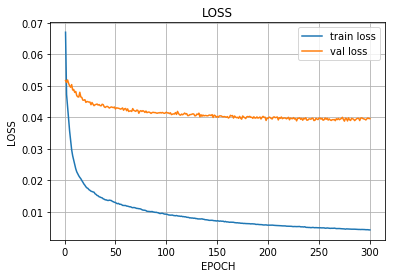

In [34]:
recommender_AE = get_recommender_AE()

By closely monitoring the training-validation loss, we are able to tune the model to prevent overfitting.

## Make recommendation
After training both recommenders, it is time to examine their performance by their rating predictions. For matrix factorization, we obtain a dense user-song rating matrix by multiplying the user-latent and song-latent matrixes. For the autoencoder predicition, we will pass the training data into the foward loop and obtain a dense matrix. Subsequently, we will compare the predicted matrix from the two recommender against the unseen rating in the test set.

### Matrix Factorization Prediction


In [37]:
# loading test data
test_data = matrix_test.toarray()
pred_MF = (svd_u@np.diag(svd_s))@svd_vt

### Autoencoder Prediction


In [38]:
train_data = matrix_train.toarray()
tensor = torch.from_numpy(train_data).float()
tensor = tensor.to(device)

with torch.no_grad():
    recommender_AE.eval()
    pred_AE = recommender_AE(tensor)

pred_AE = pred_AE.to("cpu").detach().numpy()

## Analysis
After each recommender systems had made their prediction, we can compare it with a user's actual rating in the test data, which the recommender had not seen during training. Here we visualize in a row, the user's actual rating and the predictions made by both matrix factorization recommender and autoencoder recommender. To facilitate understanding, we have mapped the domain of the rating [0.1, 1] to a blue spectrum (from the lightest to darkest).

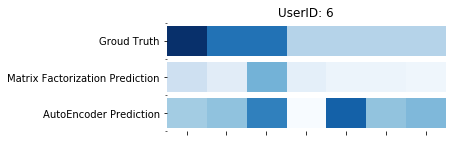

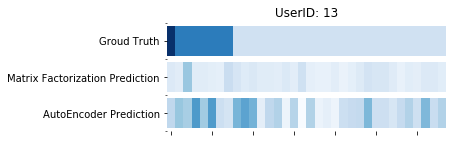

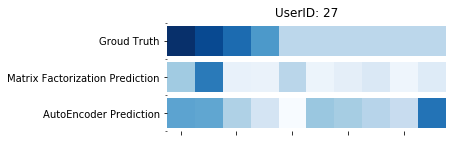

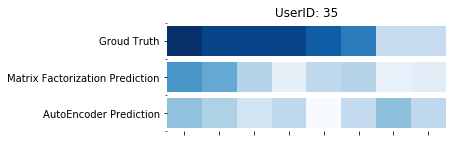

In [45]:
from matplotlib import colors
import matplotlib.pyplot as plt

def plotMatrix(lst, user_id):
    temp = [i for i in lst]
    lst = temp
    fig, ax = plt.subplots(1, 1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
        
    fig.set_size_inches(5, 2)
    intersection_matrix = np.array(lst)

    ax.imshow(intersection_matrix, cmap=plt.cm.Blues, aspect='auto', interpolation='nearest')
    ax.set_yticks(np.arange(-0.5, 3, 1), minor=True);
    ax.grid(which='minor', color='w', linestyle='-', linewidth=6)

    labels = ['Groud Truth', 'Matrix Factorization Prediction', 'AutoEncoder Prediction']

    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)
    ax.set_xticklabels([])

    ax.set_title("UserID: %s" % user_id)
    
    
def predictionCompare(user_id):
    rating_threshold = 0
    actual = test_data[user_id]
    pred_MF_usr = pred_MF[user_id]
    pred_AE_usr = pred_AE[user_id]
    idx = np.where(actual > rating_threshold)

    # sort prediction by sorted test_data
    _actual = sorted(actual[idx], reverse=True)
    _pred_MF_usr = sortby(actual[idx], pred_MF_usr[idx])
    _pred_AE_usr = sortby(actual[idx], pred_AE_usr[idx])

    plotMatrix([_actual, _pred_MF_usr, _pred_AE_usr], user_id)

predictionCompare(6)
predictionCompare(13)
predictionCompare(27)
predictionCompare(35)

The above graphic visualizes the comparison between the actual and the predicted ratings for 5 different users. We observe that the performance of the recommenders are in fact, far lower than the expected performance during validation. Evidently, both matrix factorization and deep autoencoder had made an average prediction that is far lower than the actual rating (as seen in the ratively light saturation in comparison with the darker blues in the user's actual ratings). We suspect this is mainly due to the sparsity inherent in the data where given a user, the number of frequently played (or liked) songs is far smaller than songs that had only been played a few times. To further examine this, we dicided to plot the mean square both recommenders made in each range of rating (i.e.  from 0.1 to 0.2, from 0.2 to 0.4, etc).

In [46]:
"""
returns an MSE between the input matrix and the target matrix
The mask is defined by a tuple of rating threadsholds
"""
def threshold_MSE(input, target, threshold):
    diff = input - target
    start, end = threshold
    mask = np.where((target>start)&(target<end),1,0)
    return np.sum(diff ** 2 * mask) / np.sum(mask)

thresholds = [(0.1, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]
threshold_MSE_MF = []
threshold_MSE_AE = []

for t in thresholds:
    threshold_MSE_MF.append(threshold_MSE(pred_MF, test_data, t))
    threshold_MSE_AE.append(threshold_MSE(pred_AE, test_data, t))

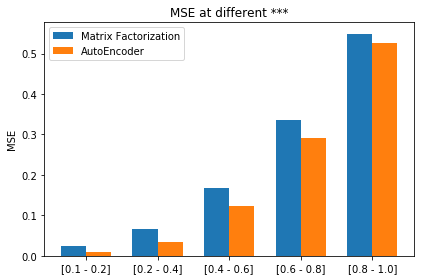

In [47]:
def plotDoubleBar(lst1, lst2):
    labels = ['[0.1 - 0.2]', '[0.2 - 0.4]', '[0.4 - 0.6]', '[0.6 - 0.8]', '[0.8 - 1.0]']
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, lst1, width, label='Matrix Factorization')
    rects2 = ax.bar(x + width/2, lst2, width, label='AutoEncoder')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('MSE')
    ax.set_title('MSE at different ***')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()
    
Factorization_means = threshold_MSE_MF
AutoEncoder_means = threshold_MSE_AE
plotDoubleBar(Factorization_means, AutoEncoder_means)

Unsurprisingly, the result matches with our expectation. We see that both recommenders had made far smaller of a mistake when predicting reatings close from 0.1 to 0.4, (a.k.a songs _not_ prefered by the user) while the mean square error gradually increases toward songs most liked by the users. This is, at least partially, in agreement with our hypothesis that the paucity of data in the songs with most liked (with most play counts) has lead to the recommender's poor performance in predicting songs with high ratings. Furthermore, to our surprise, we have also observed that the deep autoencoder performs marginally better than traditional matrix factorization. 

In [49]:
default_threshold = (0, 1)
test_error_MF = threshold_MSE(pred_MF, test_data, default_threshold)
test_error_AE = threshold_MSE(pred_AE, test_data, default_threshold)
print("MF Test Error: ", test_error_MF)
print("AE Test Error: ", test_error_AE)

MF Test Error:  0.0744864442121783
AE Test Error:  0.06296188026915885


## Examine recommendation:
Finally, we have used the recommender system to yeild a set of songs unseen in the user's training, val and test data. To our satisfaction, we have observed that the artists recommended did appeared serveral times in the user's play history. Thus, validating our recommender. 

In [36]:
combined_matrix = (matrix_train+matrix_val+matrix_test).toarray()
uid = np.random.choice(user_list, 10)

def sortby(X, Y):
    return [y for x, y in sorted(zip(X, Y), reverse=True, key=lambda x: x[0])]

def recommend(uid, k=10, combined_matrix=combined_matrix):
    
    print('user id:', uid)
    tensor = torch.from_numpy(combined_matrix[uid]).float().to(device)

    with torch.no_grad():
        recommender_AE.eval()
        pred_rating = recommender_AE(tensor).to('cpu').tolist()

    idx = sortby(pred_rating, list(range(len(pred_rating))))
    pred_artist = set()
    pred_songs = []
    for i in range(k):
        pred_artist.add(song_indices[idx[i]][0])
        pred_songs.append([pred_rating[idx[i]], song_indices[idx[i]], 0])

    for song, playcount in user_play_dict[user_indices[uid]].items():
        for i in range(len(pred_songs)):
            if song[0] == pred_songs[i][1][0]:
                pred_songs[i][2] += 1

    print("rating\tsong\t\t\t\t\tartist\t\t\tartist listened")
    for p in pred_songs:
        artist = p[1][0] if len(p[1][0]) <= 20 else p[1][0][:17]+'...'
        song = p[1][1] if len(p[1][1]) <= 30 else p[1][1][:27]+'...'
        
        print("%.3f\t%-35s\t%-25s\t%3d"%(p[0], song, artist, p[2]))
    print('\n')

for i in uid:
    recommend(i)

user id: 1874
rating	song					artist			artist listened
0.672	It Was in Me                       	Avril Lavigne            	  1
0.589	Owner of a Lonely Heart            	Yes                      	  0
0.563	Falling                            	Trevor Daniel            	  0
0.561	Yesterday - Remastered 2009        	The Beatles              	  0
0.553	Radio Friendly Unit Shifter        	Nirvana                  	  0
0.543	Jewels Of The Sky: Inscription     	Matana Roberts           	  0
0.542	Another One Bites The Dust ...     	Queen                    	  0
0.537	Just Wait Til Next Year            	John Maus                	  0
0.530	Guilty Party                       	The National             	  1
0.519	I Apologise If You Feel Som...     	Bring Me the Horizon     	  0


user id: 2266
rating	song					artist			artist listened
0.663	Bosses Hang, Pt. I                 	Godspeed You! Bla...     	  0
0.502	Almost Had To Start A Fight...     	Parquet Courts           	  0
0.491	Batuka            

## Conclusion
The result of our studies had shown the limitation of user-based collaborative filtering. Dispite the obvious advantages of a user-based approach: no need for specific domain knowledge of song (or other products and services) and the ability to rely on user simlarity for prediction, its shortcomings are also well-explored: the prediction of the recommender is heaviliy-biased by the distribution of the data. In an effort to perform dimension reduction while minimizing reconstruction loss, we see that both recommenders have learned to make predictions closely following values of the majority ratings, which is low amongst most songs listened to by users on Last.fm. 

## Future Work
The fact that modern deep learning technique had only shown marginal advantage over traditional matrix factorization had has prompted us to think of ways to imporve existing collaborative filtering techniques. 

For the autoencoder recommender, one way to mitigate the network from becoming biased toward extremely sparse and heavily skewed data is to regularize the loss during training. For instance, we might multiply the existing loss with a frequency indicator such that we penalize less on frequently appeared, low-rating songs and more on songs that rarely occurs but heavily favored by the users.

Alternatively, we are eager to compare user-based collaborative filtering with content-based approaches even though the later has a more complex input features, for user similarity becomes a more elusive concept when the product or services to recommend becomes increasingly complex (such as those sold on Amazon.com). Ultimately, a combination of the two approaches might be able to compensate pitfalls in one another and lead to better recommendations for the users.

## Reference

- [AutoRec: Autoencoders Meet Collaborative Filtering](http://users.cecs.anu.edu.au/~u5098633/papers/www15.pdf)

- [Collaborative Filtering with Stacked Denoising AutoEncoders and Sparse Inputs](https://hal.inria.fr/hal-01256422v1/document)

- [User Preference Learning in Multi-criteria Recommendations using Stacked Auto Encoders](http://delivery.acm.org/10.1145/3250000/3240412/p475-tallapally.pdf?ip=128.237.116.47&id=3240412&acc=ACTIVE%20SERVICE&key=A792924B58C015C1%2E5A12BE0369099858%2E4D4702B0C3E38B35%2E4D4702B0C3E38B35&__acm__=1575679920_47a3fdea314cf7ec643731dc63f78fda)

- [A Comprehensive Collaborative Filtering Approach using Autoencoder in Recommender System](http://delivery.acm.org/10.1145/3340000/3330518/p185-Hasan.pdf?ip=128.237.116.47&id=3330518&acc=ACTIVE%20SERVICE&key=A792924B58C015C1%2E5A12BE0369099858%2E4D4702B0C3E38B35%2E4D4702B0C3E38B35&__acm__=1575679993_d72ebaf597b35cad0c9ff0b976800fa0)